<a href="https://colab.research.google.com/github/aulia-anhar/Corb_Recomendation-/blob/main/Salinan_tugas_individu01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librany

In [ ]:
import urllib.request
import zipfile
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import cv2
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import SGD, Adam
# Mengaktifkan alokasi memori GPU yang tumbuh secara dinamis
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


EDA 1



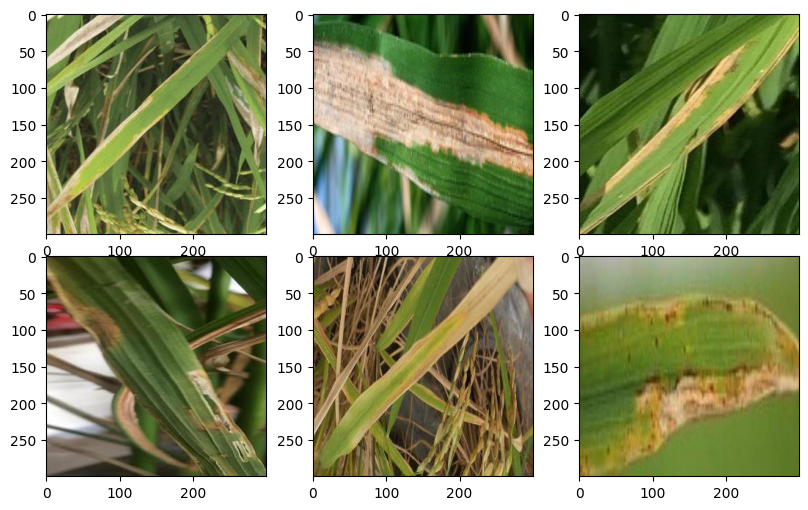

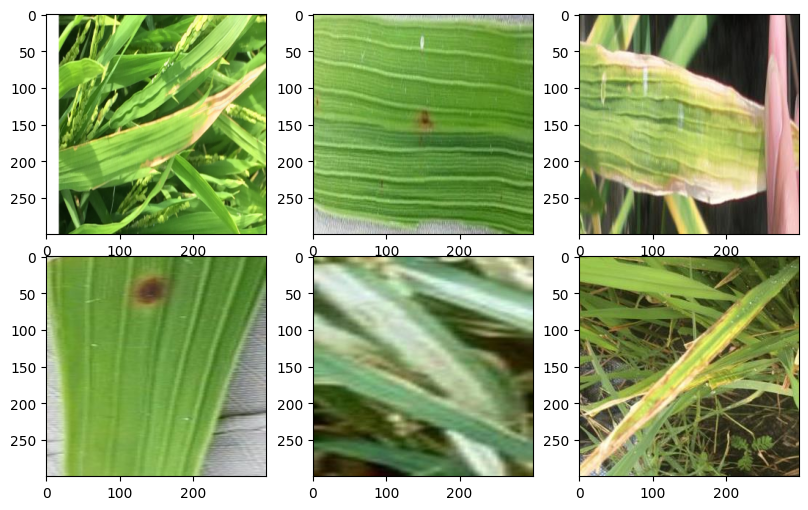

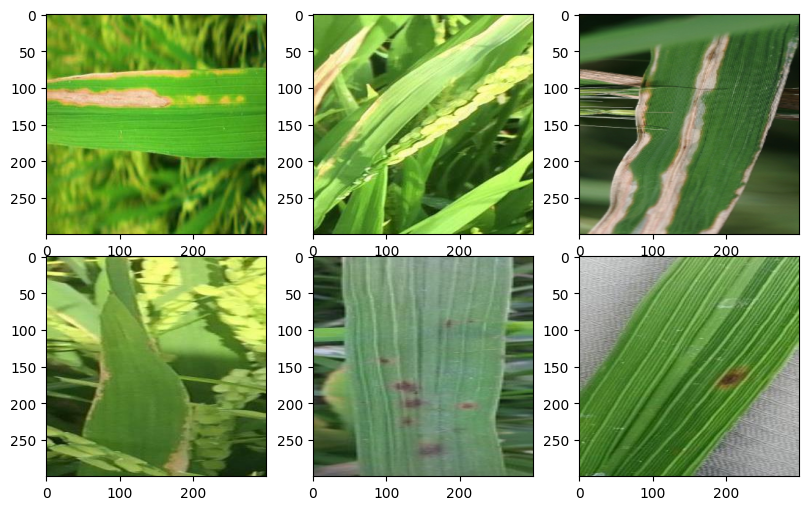

In [ ]:

image_dir = "/content/drive/MyDrive/Semester 4/LI/rice leaf diseases dataset" #baca direktori
image_files = []
for subdir in os.listdir(image_dir):
    subdir_path = os.path.join(image_dir, subdir)
    if os.path.isdir(subdir_path):
        image_files.extend([os.path.join(subdir_path, filename) for filename in os.listdir(subdir_path) if filename.endswith((".jpg", ".png", ".jpeg"))])

    # Randomly select 6 image files
    random_images = random.sample(image_files, 6)

    # Create a 2x3 grid for displaying the images
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    for i, ax in enumerate(axes.flatten()):
        img = Image.open(random_images[i])
        ax.imshow(img)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [ ]:
import os
import cv2
import numpy as np

# Menentukan ukuran tinggi dan lebar gambar
height = 128
width = 128
dim = (width, height)

# Mengumpulkan data citra yang akan dibuka dalam satu array
tampungan_data = []
tampungan_label = []

for path, subdirs, files in os.walk(image_dir):
    for name in files:
        img_path = os.path.join(path, name)  # Baca path data
        if img_path.lower().endswith((".jpg", ".png", ".jpeg")):  # Dengan file berekstensi jpg, png, atau jpeg
            img = cv2.imread(img_path)  # Baca gambar

            path_parts = path.split('/')
            # Mengambil elemen terakhir dari path_parts sebagai kata terakhir
            last_word = path_parts[-1]
            # Preprocessing data / segmentasi boleh dilakukan di sini
            resized = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)  # Resize
            tampungan_data.append(resized / 255.0)  # Menumpuk gambar blur pada array tampungan dan di-sampling
            tampungan_label.append(last_word)

X = np.array(tampungan_data)
y = np.array(tampungan_label)


In [ ]:
print (y)

['Bacterialblight' 'Bacterialblight' 'Bacterialblight' ... 'Leafsmut'
 'Leafsmut' 'Leafsmut']


In [ ]:
# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Fit label ke encoder
label_encoder.fit(y)

# Transformasi label teks menjadi angka
encoded_labels = label_encoder.transform(y)

# Tampilkan hasil
print("Label teks:", y)
print("Label termodifikasi:", encoded_labels)

# Kembalikan angka-angka ke label awal
decoded_labels = label_encoder.inverse_transform(encoded_labels)
print("Angka-angka yang dikembalikan ke label teks:", decoded_labels)
list_label=np.unique(y) #mendapatkan label unik
label_dict = {label: idx for idx, label in enumerate(list_label)} #masukkan dalam list
print(label_dict)

Label teks: ['Bacterialblight' 'Bacterialblight' 'Bacterialblight' ... 'Leafsmut'
 'Leafsmut' 'Leafsmut']
Label termodifikasi: [0 0 0 ... 2 2 2]
Angka-angka yang dikembalikan ke label teks: ['Bacterialblight' 'Bacterialblight' 'Bacterialblight' ... 'Leafsmut'
 'Leafsmut' 'Leafsmut']
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}


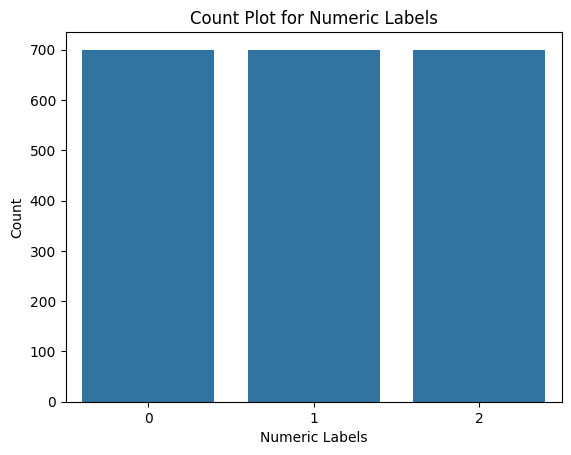

In [ ]:
# Visualisasikan dalam jumlah dalam plot
sns.countplot(x=encoded_labels)
plt.xlabel('Numeric Labels')
plt.ylabel('Count')
plt.title('Count Plot for Numeric Labels')
plt.show()

In [ ]:
import os

folder_path = "drive/MyDrive/Semester 4/CV/tugas individu/bike"  # Ganti dengan path folder yang sesuai
image_extensions = (".jpg", ".png", ".jpeg")  # Ekstensi file gambar yang ingin dihitung

# Menghitung jumlah file gambar
image_count = len([filename for filename in os.listdir(folder_path) if filename.lower().endswith(image_extensions)])

print(f"Jumlah file gambar dalam folder: {image_count}")


Jumlah file gambar dalam folder: 150


SPLIT DATA

In [ ]:
from sklearn.model_selection import train_test_split #library untuk train test split

#melakukan splitting data
# First, split data into train and temp sets (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, encoded_labels, test_size=0.25, random_state=42, stratify=encoded_labels)

# Next, split the temp set into validation and test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print the sizes of each set
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (1575, 128, 128, 3) (1575,)
Validation set: (262, 128, 128, 3) (262,)
Test set: (263, 128, 128, 3) (263,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 as Mdl
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mengaktifkan alokasi memori GPU yang tumbuh secara dinamis
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)

MODELING

In [ ]:
tf.keras.backend.clear_session()

def mobilenet(img_height,img_width, channel):
    base_model = Mdl(weights="imagenet", include_top=False, input_shape=(img_height, img_width, channel)) #model TF IMAGENET

    for layer in base_model.layers: # FREEZE ALL LAYER
        layer.trainable = False

    model = tf.keras.models.Sequential()
    model.add(base_model) # tambahkan beberapa layer
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    predictions = tf.keras.layers.Dense(1, activation="sigmoid")(x) # softmax untuk multiclass
    model = Model(inputs=model.input, outputs=predictions)
    return model

model1 = mobilenet(128, 128, 3)
model1.summary()
# Compile model
opt = Adam(lr=0.001)
model1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128_input  [(None, 128, 128, 3)]     0         
  (InputLayer)                                                   
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 1)                 20481     
                                                                 
Total params: 2278465 (8.69 MB)
Trainable params: 20481 (80.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_______________________

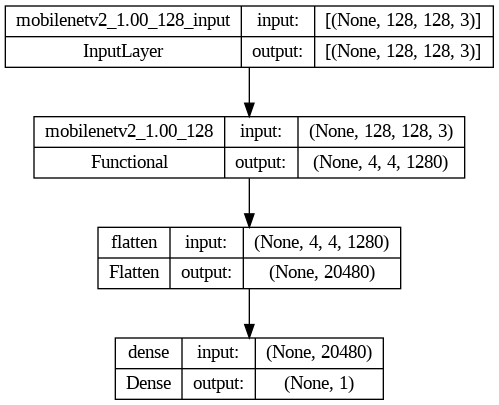

In [ ]:
# Visualisasi model Keras

from tensorflow.keras.utils import plot_model

plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
tf.keras.backend.clear_session() #hapus cache keras
history = model1.fit(X_train,y_train, validation_data=(X_val,y_val), batch_size=32, epochs=10,
                          verbose=1, workers=-1) #train model

# Simpan model ke dalam file H5
model1.save("weight/model3.h5")

Epoch 1/10
50/50 [==============================] - 10s 75ms/step - loss: -9.0918 - accuracy: 0.3778 - val_loss: -17.6803 - val_accuracy: 0.4275
Epoch 2/10
50/50 [==============================] - 1s 20ms/step - loss: -29.4657 - accuracy: 0.3860 - val_loss: -35.4359 - val_accuracy: 0.4008
Epoch 3/10
50/50 [==============================] - 1s 20ms/step - loss: -49.5230 - accuracy: 0.3962 - val_loss: -52.7766 - val_accuracy: 0.3779
Epoch 4/10
50/50 [==============================] - 1s 22ms/step - loss: -69.3963 - accuracy: 0.4013 - val_loss: -69.5398 - val_accuracy: 0.3855
Epoch 5/10
50/50 [==============================] - 1s 23ms/step - loss: -89.7400 - accuracy: 0.3937 - val_loss: -87.4628 - val_accuracy: 0.3740
Epoch 6/10
50/50 [==============================] - 1s 27ms/step - loss: -109.8922 - accuracy: 0.3822 - val_loss: -105.0787 - val_accuracy: 0.3855
Epoch 7/10
50/50 [==============================] - 1s 20ms/step - loss: -130.6192 - accuracy: 0.3924 - val_loss: -123.0837 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


EVALUASI

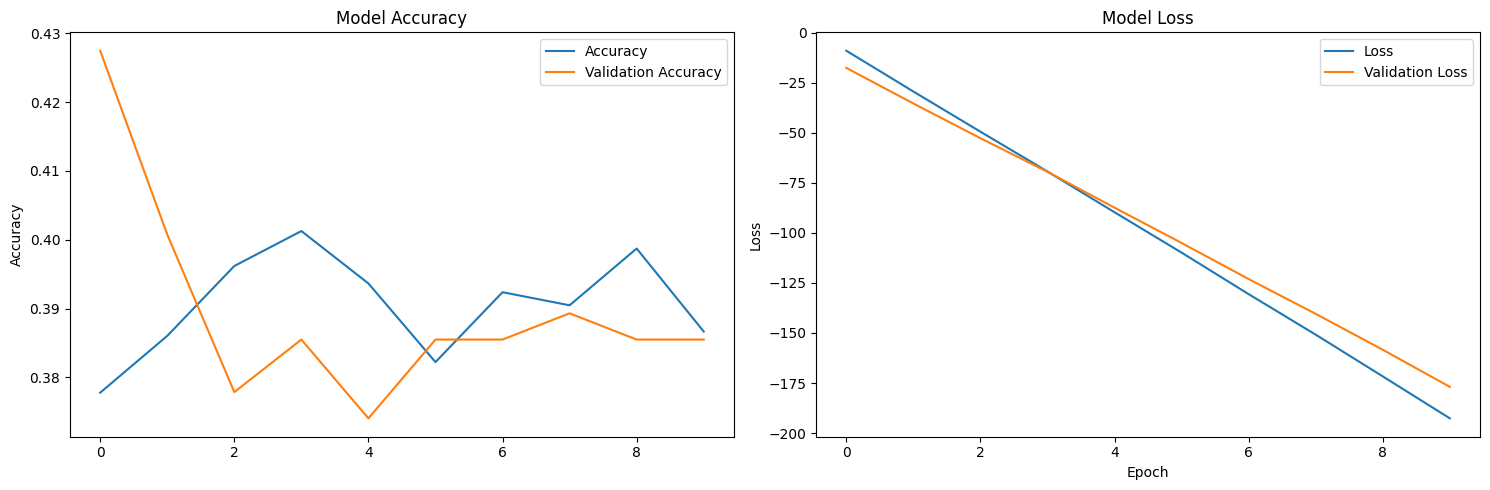

In [ ]:
# Plot grafik kiri (akurasi dan akurasi validasi)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

# Plot grafik kanan (loss dan loss validasi)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])
plt.tight_layout()

# Tampilkan grafik
plt.show()

9/9 [==============================] - 1s 19ms/step


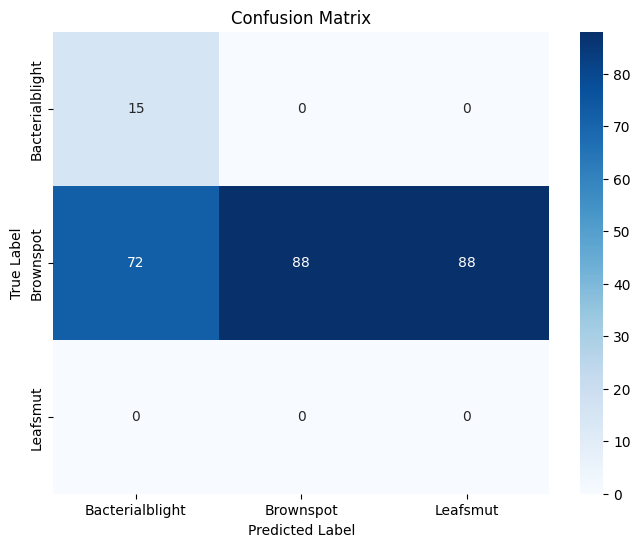

In [ ]:
y_pred = model1.predict(X_test) #test model
# Ambang batas untuk binary prediction
threshold = 0.5

# Mengubah probabilitas menjadi binary prediction
binary_predictions = (y_pred > threshold).astype(int)
cm = confusion_matrix(binary_predictions, y_test)#plot cm
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict, yticklabels=label_dict)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report = classification_report(binary_predictions, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.17      1.00      0.29        15
           1       1.00      0.35      0.52       248
           2       0.00      0.00      0.00         0

    accuracy                           0.39       263
   macro avg       0.39      0.45      0.27       263
weighted avg       0.95      0.39      0.51       263



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TFL

In [ ]:
contoh = np.array([1,2,3,4])
print(contoh[:2]) #ambil didepan
print(contoh[2:]) #ambil belakang

[1 2]
[3 4]


In [ ]:
tf.keras.backend.clear_session()

def mobilenet(img_height,img_width, channel):
    base_model = Mdl(weights="imagenet", include_top=False, input_shape=(img_height, img_width, channel)) #model TF IMAGENET

    # Tentukan berapa banyak lapisan yang akan difreez
    jumlah_lapisan = len(base_model.layers)
    print("Jumlah lapisan dalam model dasar:", jumlah_lapisan)
    freeze_layers = int(jumlah_lapisan * 0.6)
    print(freeze_layers)

    for layer in base_model.layers[:jumlah_lapisan]:
        layer.trainable = False

    model = tf.keras.models.Sequential()
    model.add(base_model) # tambahkan beberapa layer
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.Dense(64, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(1, activation="sigmoid")(x) # softmax untuk multiclass
    model = Model(inputs=model.input, outputs=predictions)
    return model

model2 = mobilenet(128, 128, 3)
model2.summary()
# Compile model
opt = Adam(lr=0.001)
model2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Jumlah lapisan dalam model dasar: 154
92
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128_input  [(None, 128, 128, 3)]     0         
  (InputLayer)                                                   
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 1)                 20481     
                                                                 
Total params: 2278465 (8.69 MB)
Trainable params: 20481 (80.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_____________________________________________

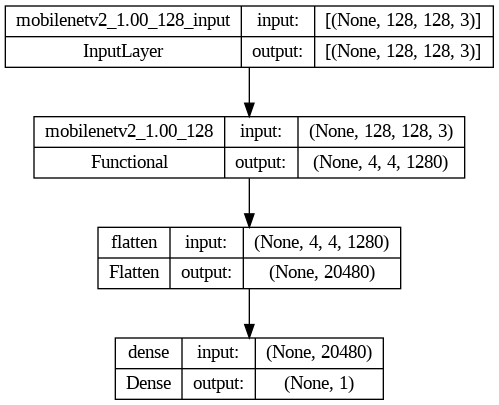

In [ ]:
# Visualisasi model Keras

from tensorflow.keras.utils import plot_model

plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
tf.keras.backend.clear_session() #hapus cache keras
history = model2.fit(X_train,y_train, validation_data=(X_val,y_val), batch_size=64, epochs=20,
                          verbose=2, workers=-1) #train model

# Simpan model ke dalam file H5
model2.save("weight/model2.h5")

Epoch 1/20
25/25 - 7s - loss: -3.9652e+00 - accuracy: 0.3530 - val_loss: -8.9164e+00 - val_accuracy: 0.4275 - 7s/epoch - 284ms/step
Epoch 2/20
25/25 - 1s - loss: -1.5678e+01 - accuracy: 0.4006 - val_loss: -1.8884e+01 - val_accuracy: 0.3779 - 809ms/epoch - 32ms/step
Epoch 3/20
25/25 - 1s - loss: -2.7313e+01 - accuracy: 0.3911 - val_loss: -2.9270e+01 - val_accuracy: 0.3893 - 836ms/epoch - 33ms/step
Epoch 4/20
25/25 - 1s - loss: -3.9433e+01 - accuracy: 0.3898 - val_loss: -3.9973e+01 - val_accuracy: 0.3893 - 809ms/epoch - 32ms/step
Epoch 5/20
25/25 - 1s - loss: -5.2002e+01 - accuracy: 0.3956 - val_loss: -5.0587e+01 - val_accuracy: 0.3779 - 808ms/epoch - 32ms/step
Epoch 6/20
25/25 - 1s - loss: -6.4041e+01 - accuracy: 0.3771 - val_loss: -6.2155e+01 - val_accuracy: 0.3817 - 843ms/epoch - 34ms/step
Epoch 7/20
25/25 - 1s - loss: -7.6983e+01 - accuracy: 0.4063 - val_loss: -7.2696e+01 - val_accuracy: 0.3893 - 810ms/epoch - 32ms/step
Epoch 8/20
25/25 - 1s - loss: -8.9692e+01 - accuracy: 0.3867 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


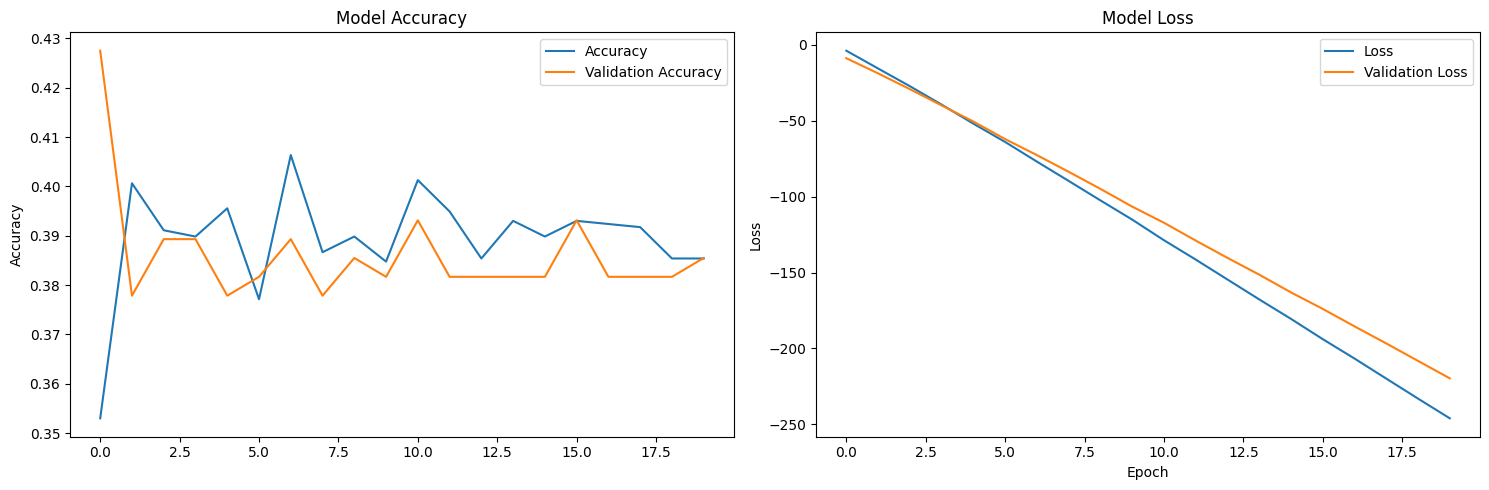

In [ ]:
# Plot grafik kiri
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

# Plot grafik kanan
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])
plt.tight_layout()
# Simpan gambar ke file
plt.show()

9/9 [==============================] - 1s 19ms/step


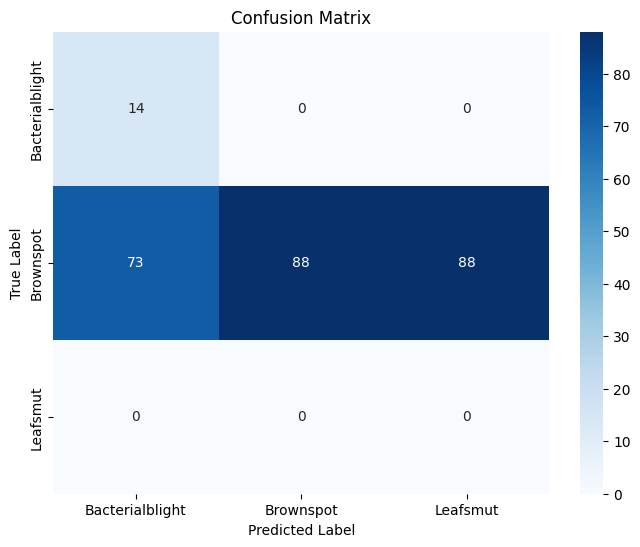

In [ ]:
y_pred = model2.predict(X_test) #test model
# Ambang batas untuk binary prediction
threshold = 0.5

# Mengubah probabilitas menjadi binary prediction
binary_predictions = (y_pred > threshold).astype(int)
cm = confusion_matrix(binary_predictions, y_test)#plot cm
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict, yticklabels=label_dict)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report = classification_report(binary_predictions, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.16      1.00      0.28        14
           1       1.00      0.35      0.52       249
           2       0.00      0.00      0.00         0

    accuracy                           0.39       263
   macro avg       0.39      0.45      0.27       263
weighted avg       0.96      0.39      0.51       263



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# @title Model 3
tf.keras.backend.clear_session()

def mobilenet(img_height,img_width, channel):
    base_model = Mdl(weights="imagenet", include_top=False, input_shape=(img_height, img_width, channel)) #model TF IMAGENET

    # Tentukan berapa banyak lapisan yang akan difreez
    jumlah_lapisan = len(base_model.layers)
    print("Jumlah lapisan dalam model dasar:", jumlah_lapisan)
    freeze_layers = int(jumlah_lapisan * 0.7)
    print(freeze_layers)

    for layer in base_model.layers[:jumlah_lapisan]:
        layer.trainable = False

    model = tf.keras.models.Sequential()
    model.add(base_model) # Tambahkan beberapa layer
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = Dropout(0.3)(x)  # Tambahkan dropout dengan rate 30%
    x = Dense(64, activation='relu', kernel_regularizer=l1(0.001))(x)  # Layer dengan regularisasi L1
    # x = Dropout(0.25)(x)  # Tambahkan dropout dengan rate 25% setelah dense layer
    predictions = tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=l2(0.001))(x)  # Output layer dengan regularisasi L2
    # predictions = tf.keras.layers.Dense(1, activation="sigmoid")(x)  # Output layer dengan regularisasi L2

    model = Model(inputs=model.input, outputs=predictions)
    return model

model3 = mobilenet(128, 128, 3)
model3.summary()
# Compile model
opt = Adam(lr=0.001)
model3.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Jumlah lapisan dalam model dasar: 154
107
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128_input  [(None, 128, 128, 3)]     0         
  (InputLayer)                                                   
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dropout (Dropout)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 64)                1310784   
                                                                 
 dense_1 (Dense)   

In [ ]:
# Visualisasi model Keras

from tensorflow.keras.utils import plot_model

plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

NameError: name 'model3' is not defined

In [ ]:
tf.keras.backend.clear_session() # hapus cache keras
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20,
                          verbose=1, workers=-1, callbacks=[early_stopping]) # train model

# Simpan model ke dalam file H5
model3.save("weight/model3.h5")

Epoch 1/20
50/50 [==============================] - 8s 57ms/step - loss: -39.5579 - accuracy: 0.3771 - val_loss: -100.1217 - val_accuracy: 0.4313
Epoch 2/20
50/50 [==============================] - 1s 22ms/step - loss: -206.1870 - accuracy: 0.4038 - val_loss: -283.2738 - val_accuracy: 0.3626
Epoch 3/20
50/50 [==============================] - 1s 22ms/step - loss: -465.8082 - accuracy: 0.3803 - val_loss: -570.3516 - val_accuracy: 0.3931
Epoch 4/20
50/50 [==============================] - 1s 22ms/step - loss: -849.8192 - accuracy: 0.3962 - val_loss: -945.2449 - val_accuracy: 0.3969
Epoch 5/20
50/50 [==============================] - 1s 22ms/step - loss: -1350.8625 - accuracy: 0.4006 - val_loss: -1454.0542 - val_accuracy: 0.3931
Epoch 6/20
50/50 [==============================] - 1s 22ms/step - loss: -2008.5276 - accuracy: 0.4000 - val_loss: -2089.3904 - val_accuracy: 0.3969
Epoch 7/20
50/50 [==============================] - 1s 22ms/step - loss: -2823.1245 - accuracy: 0.4032 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


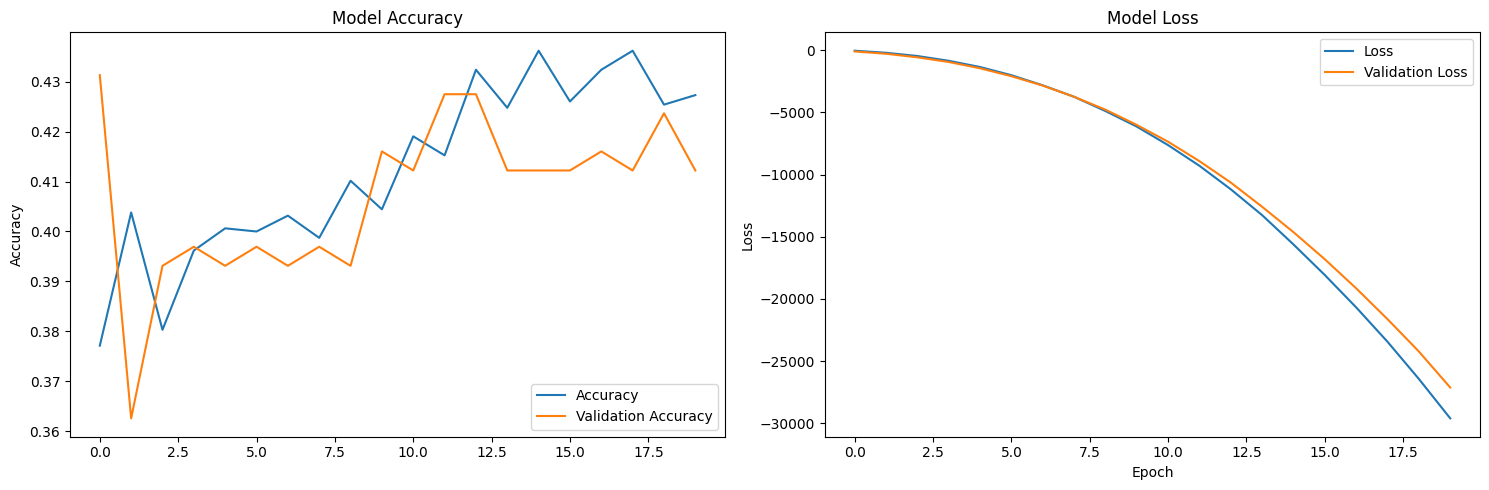

In [ ]:
# Plot grafik kiri (akurasi dan akurasi validasi)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

# Plot grafik kanan (loss dan loss validasi)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])
plt.tight_layout()

# Tampilkan grafik
plt.show()

9/9 [==============================] - 1s 18ms/step


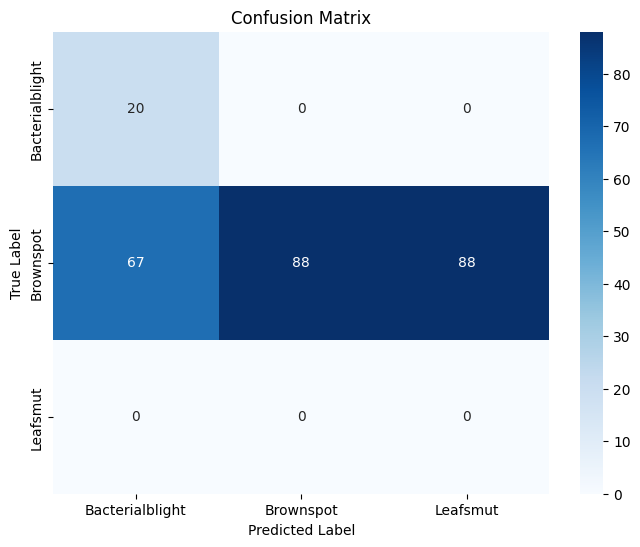

In [ ]:
y_pred = model3.predict(X_test) # test model
# Ambang batas untuk binary prediction
threshold = 0.5

# Mengubah probabilitas menjadi binary prediction
binary_predictions = (y_pred > threshold).astype(int)
cm = confusion_matrix(binary_predictions, y_test) # plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict, yticklabels=label_dict)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report = classification_report(binary_predictions, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.23      1.00      0.37        20
           1       1.00      0.36      0.53       243
           2       0.00      0.00      0.00         0

    accuracy                           0.41       263
   macro avg       0.41      0.45      0.30       263
weighted avg       0.94      0.41      0.52       263



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import os  # Operating system interfaces
import tensorflow as tf                                    # TensorFlow deep learning framework
import matplotlib.pyplot as plt                            # Plotting library
import matplotlib.image as mpimg                           # Image loading and manipulation library
from tensorflow.keras.models import Sequential, Model      # Sequential and Functional API for building models
from tensorflow.keras.optimizers import Adam               # Adam optimizer for model training
from tensorflow.keras.callbacks import EarlyStopping       # Early stopping callback for model training
from tensorflow.keras.regularizers import l1, l2           # L1 and L2 regularization for model regularization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for images
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization
# Various types of layers for building neural networks
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception, VGG16, VGG19   # Pre-trained models for transfer learnin

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Semester 4/LI/rice leaf diseases dataset',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

train_data = train_data.map(lambda x, y: (x / 255.0, y))

Found 2097 files belonging to 3 classes.


In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Semester 4/LI/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

val_data = val_data.map(lambda x, y: (x / 255.0, y))

Found 303 files belonging to 3 classes.


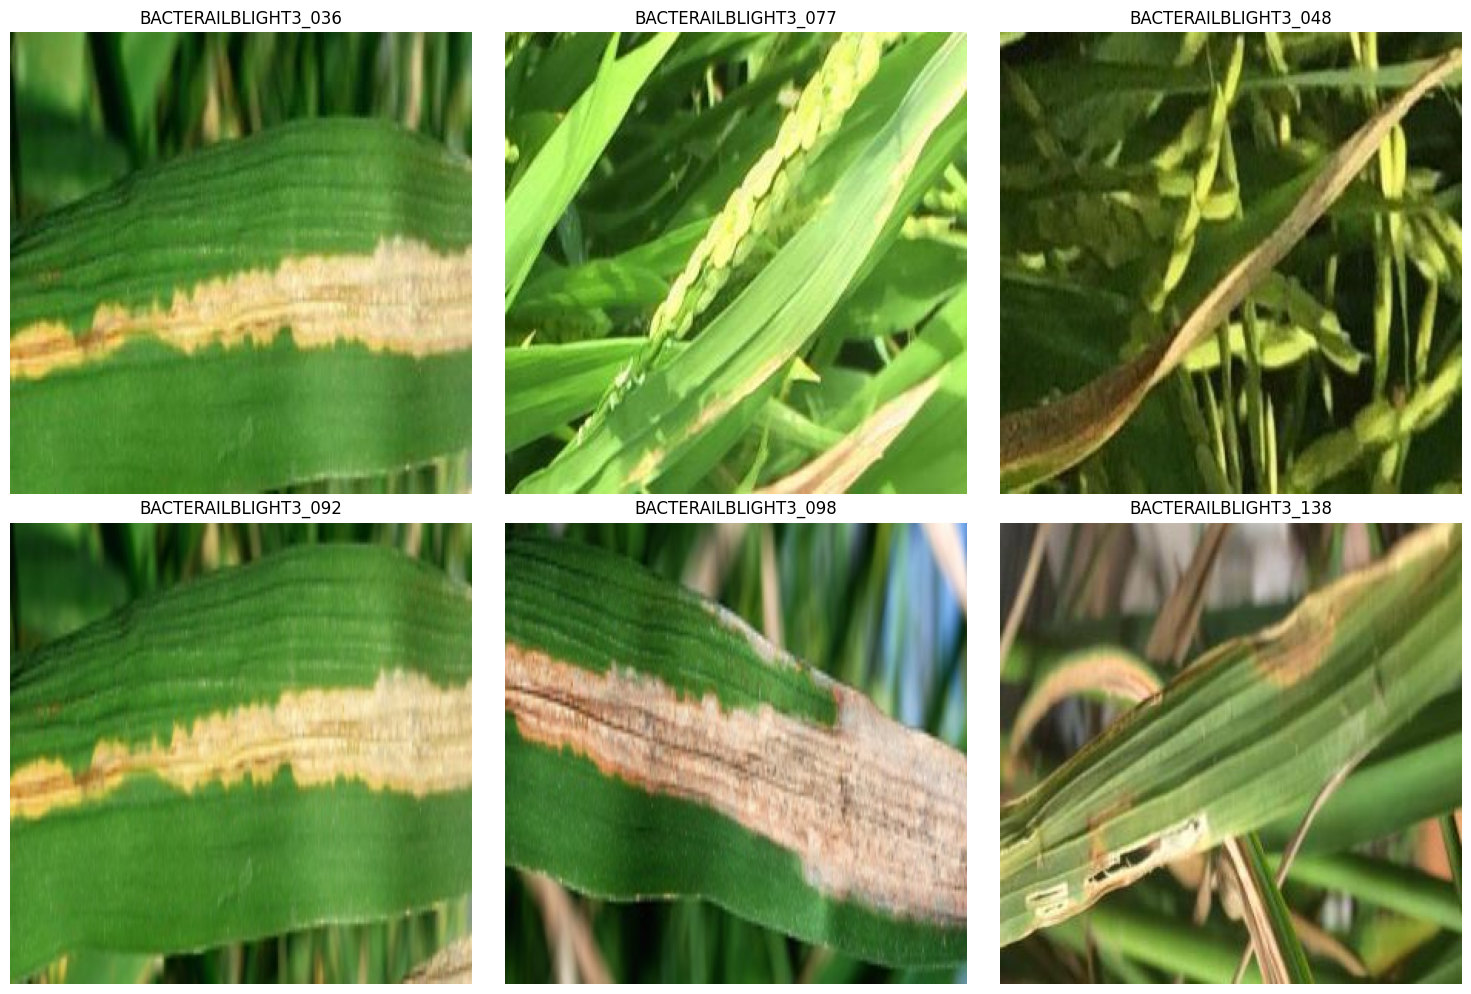

In [ ]:
# Path to the directory containing images
path = "/content/drive/MyDrive/Semester 4/LI/rice leaf diseases dataset/Bacterialblight"

# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

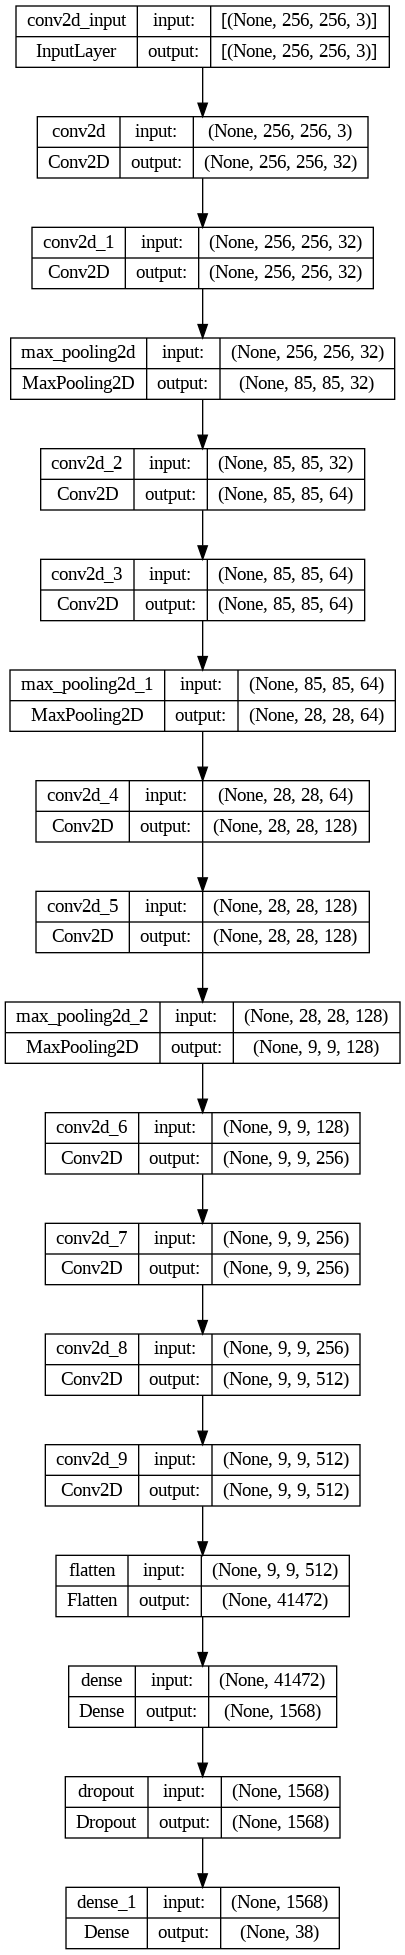

In [ ]:
# Visualisasi model Keras

from tensorflow.keras.utils import plot_model

plot_model(model4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Dengan asumsi Anda memiliki direktori data pelatihan 'train_data' dan direktori data pengujian 'test_data'

# Buat train_gen dan test_gen menggunakan image_dataset_from_directory
train_gen = image_dataset_from_directory(
    '/content/drive/MyDrive/Semester 4/LI/rice leaf diseases dataset',  # Ganti 'train_data_dir' dengan nama direktori yang sebenarnya
    labels='inferred',
    label_mode='categorical',  # atau 'binary' atau 'sparse' tergantung pada label Anda
    image_size=(256, 256),
    interpolation='nearest',
    batch_size=32,
    shuffle=True
)

test_gen = image_dataset_from_directory(
    '/content/drive/MyDrive/Semester 4/LI/rice leaf diseases dataset',  # Ganti 'test_data_dir' dengan nama direktori yang sebenarnya
    labels='inferred',
    label_mode='categorical',  # atau 'binary' atau 'sparse' tergantung pada label Anda
    image_size=(256, 256),
    interpolation='nearest',
    batch_size=32,
    shuffle=False
)

tf.keras.backend.clear_session()
ep = 10
history = model4.fit(train_gen,  # Gunakan model4.fit, bukan model4.fit_generator
          validation_data=test_gen,
          epochs = ep) # train model

# Simpan model ke dalam file H5
model3.save("weight/model3.h5")

Found 2100 files belonging to 3 classes.
Found 2100 files belonging to 3 classes.
Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-45-da6ce7385b08>", line 26, in <cell line: 26>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,38] and labels shape [96]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_7101]